**Run the demo.** Run the following cells to compute semantic correspondences for real image pairs.

In [1]:
%load_ext autoreload
%autoreload 2
from archs.stable_diffusion.diffusion import latent_to_image
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import (
  process_image,
  rescale_points,
  draw_correspondences,
  compute_pck,
  find_nn_source_correspondences,
  find_best_buddies_correspondences,
  find_cyclical_correspondences,
)
import os
import random
import torch

import einops
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import json
import torchvision

from extract_hyperfeatures import load_models
import importlib
import archs.correspondence_utils


In [2]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "configs/real.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)

c:\Users\Q613871\Desktop\Code\diffusion_hyperfeatures\Diffusion_Hyperfeatures\Lib\site-packages\diffusers\pipelines\pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1-base via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

diffusion_mode: inversion
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: 


In [3]:
importlib.reload(archs.correspondence_utils)
from archs.correspondence_utils import find_nn_source_correspondences

def load_image_pair(ann, load_size, device, image_path=""):
  img1_pil = Image.open(f"{image_path}/{ann['source_path']}").convert("RGB")
  img2_pil = Image.open(f"{image_path}/{ann['target_path']}").convert("RGB")
  source_size = img1_pil.size
  target_size = img2_pil.size

  # swap from (x, y) to (y, x)
  if "source_points" in ann:
    source_points, target_points = ann["source_points"], ann["target_points"]
    source_points = np.flip(source_points, 1)
    target_points = np.flip(target_points, 1)
    source_points = rescale_points(source_points, source_size, load_size)
    target_points = rescale_points(target_points, target_size, load_size)
  else:
    source_points, target_points = None, None

  img1, img1_pil = process_image(img1_pil, res=load_size)
  img2, img2_pil = process_image(img2_pil, res=load_size)
  img1, img2 = img1.to(device), img2.to(device)
  imgs = torch.cat([img1, img2])
  
  return source_points, target_points, img1_pil, img2_pil, imgs

def load_saliency_pair(ann, output_size, device, saliency_path=""):
  def _load_saliency(path):
    if os.path.exists(path):
      saliency_pil = Image.open(path).convert("L")
      saliency_map, _ = process_image(saliency_pil, res=output_size, range=(0, 1))
      saliency_map = einops.rearrange(saliency_map, 'b c h w -> (b c) (h w)')
    else:
      saliency_map = torch.ones((1, output_size[0] * output_size[1]))
    saliency_map = saliency_map.to(device)
    return saliency_map
  saliency_map1 = _load_saliency(f"{saliency_path}/{ann['source_path']}")
  saliency_map2 = _load_saliency(f"{saliency_path}/{ann['target_path']}")
  return saliency_map1, saliency_map2

def reshape_descriptors(img1_feats, img2_feats):
  b, d, w, h = img1_feats.shape
  descriptors1 = img1_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  descriptors2 = img2_feats.view((b, d, -1)).permute((0, 2, 1))[:, None, ...]
  return descriptors1, descriptors2

def postprocess_points(source_points, predicted_points, output_size, load_size):
  source_points = source_points.detach().cpu().numpy()
  predicted_points = predicted_points.detach().cpu().numpy()
  source_points = rescale_points(source_points, output_size, load_size)
  predicted_points = rescale_points(predicted_points, output_size, load_size)
  return source_points, predicted_points

**Compute semantic keypoint matches.** Use one of the correspondence functions:
- `nearest_neighbors`: For a set of annotated source_points, compute the nearest neighbor predicted_points.
- `best_buddies`: Compute the top-k pairs of source_points, predicted_points using the [best buddies algorithm](https://github.com/ShirAmir/dino-vit-features) (Amir et. al., ECCVW 2022).

In [4]:
image_path = "assets/spair/images"
saliency_path = "assets/spair/odise"
annotation_path = "annotations/spair_71k_test-6.json"
load_size = (256, 256)
output_size = (config["output_resolution"], config["output_resolution"])

# Select from [nearest_neighbors, best_buddies]
correspondence_function = "nearest_neighbors"
# Number of correspondences to display when using [best_buddies]
num_pairs = 10

c:\Users\Q613871\Desktop\Code\diffusion_hyperfeatures\Diffusion_Hyperfeatures\Lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
c:\Users\Q613871\Desktop\Code\diffusion_hyperfeatures\archs\aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


Source hyperfeats: tensor([[[[1.6108e-01, 2.0357e-01, 1.8705e-01,  ..., 6.7895e-02,
           8.2645e-02, 5.1983e-02],
          [2.0340e-01, 2.6498e-01, 2.4223e-01,  ..., 1.1187e-01,
           1.3082e-01, 7.3805e-02],
          [2.1362e-01, 2.7388e-01, 2.5176e-01,  ..., 1.1862e-01,
           1.3532e-01, 7.2868e-02],
          ...,
          [1.4821e-02, 2.8777e-02, 2.5891e-02,  ..., 2.7756e-03,
           5.7191e-03, 2.7574e-04],
          [1.4931e-02, 3.1208e-02, 2.7016e-02,  ..., 4.1398e-03,
           8.3652e-03, 5.0642e-04],
          [5.7130e-03, 1.0126e-02, 1.0126e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.2493e-01, 1.8867e-01, 1.7674e-01,  ..., 2.0573e-01,
           2.0395e-01, 9.3496e-02],
          [2.0905e-01, 3.1607e-01, 3.0187e-01,  ..., 3.5367e-01,
           3.4173e-01, 1.5219e-01],
          [2.0608e-01, 3.0595e-01, 2.9193e-01,  ..., 3.4397e-01,
           3.3297e-01, 1.5320e-01],
          ...,
          [4.0405e-02, 8.4516e-02, 9.860

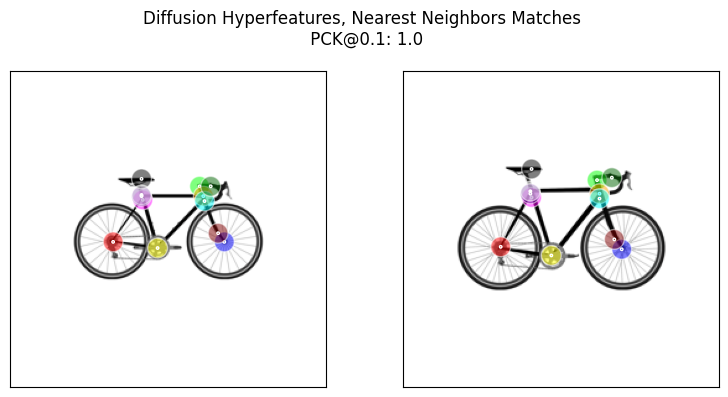

Source hyperfeats: tensor([[[[1.5997e-01, 2.0218e-01, 1.8565e-01,  ..., 6.6844e-02,
           8.1545e-02, 5.1162e-02],
          [2.0229e-01, 2.6359e-01, 2.4079e-01,  ..., 1.1065e-01,
           1.2962e-01, 7.2717e-02],
          [2.1257e-01, 2.7258e-01, 2.5046e-01,  ..., 1.1667e-01,
           1.3361e-01, 7.1728e-02],
          ...,
          [1.4712e-02, 2.8748e-02, 2.5646e-02,  ..., 2.4086e-03,
           5.1859e-03, 2.6997e-04],
          [1.4712e-02, 3.1295e-02, 2.6948e-02,  ..., 3.7619e-03,
           7.8285e-03, 5.0601e-04],
          [5.6312e-03, 1.0051e-02, 1.0051e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.2512e-01, 1.8875e-01, 1.7675e-01,  ..., 2.0444e-01,
           2.0236e-01, 9.2644e-02],
          [2.0945e-01, 3.1615e-01, 3.0189e-01,  ..., 3.5128e-01,
           3.3930e-01, 1.5055e-01],
          [2.0657e-01, 3.0614e-01, 2.9213e-01,  ..., 3.4090e-01,
           3.3007e-01, 1.5152e-01],
          ...,
          [4.0135e-02, 8.4481e-02, 9.835

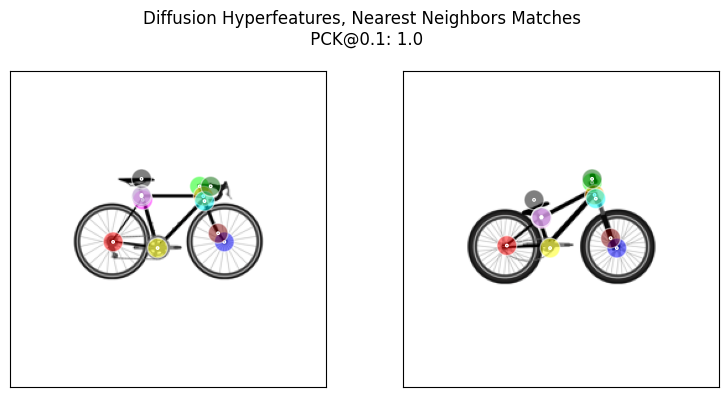

Source hyperfeats: tensor([[[[1.6091e-01, 2.0353e-01, 1.8693e-01,  ..., 6.7838e-02,
           8.2631e-02, 5.2199e-02],
          [2.0347e-01, 2.6530e-01, 2.4255e-01,  ..., 1.1172e-01,
           1.3071e-01, 7.3748e-02],
          [2.1343e-01, 2.7405e-01, 2.5196e-01,  ..., 1.1800e-01,
           1.3488e-01, 7.2701e-02],
          ...,
          [1.5088e-02, 2.9602e-02, 2.6587e-02,  ..., 2.9471e-03,
           5.7853e-03, 2.6516e-04],
          [1.5576e-02, 3.2196e-02, 2.7738e-02,  ..., 4.3096e-03,
           8.4540e-03, 5.0406e-04],
          [5.8952e-03, 1.0369e-02, 1.0369e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.2554e-01, 1.8937e-01, 1.7704e-01,  ..., 2.0482e-01,
           2.0238e-01, 9.2496e-02],
          [2.0975e-01, 3.1832e-01, 3.0351e-01,  ..., 3.5207e-01,
           3.3929e-01, 1.5001e-01],
          [2.0678e-01, 3.0771e-01, 2.9347e-01,  ..., 3.4176e-01,
           3.3024e-01, 1.5095e-01],
          ...,
          [4.1079e-02, 8.5812e-02, 9.941

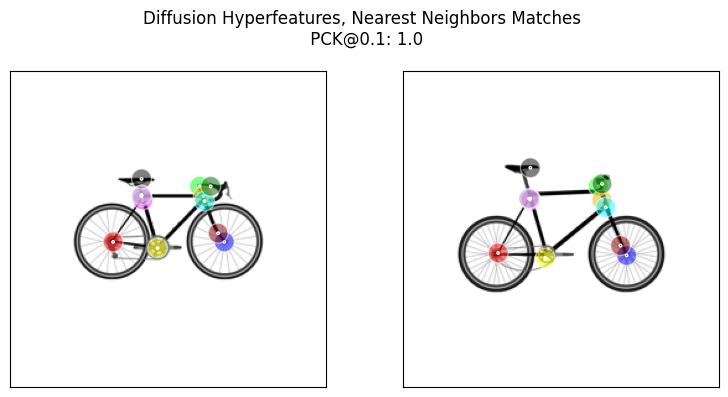

Source hyperfeats: tensor([[[[1.6133e-01, 2.0377e-01, 1.8702e-01,  ..., 6.7195e-02,
           8.1969e-02, 5.1477e-02],
          [2.0369e-01, 2.6527e-01, 2.4229e-01,  ..., 1.1099e-01,
           1.3007e-01, 7.3124e-02],
          [2.1400e-01, 2.7420e-01, 2.5182e-01,  ..., 1.1726e-01,
           1.3423e-01, 7.2330e-02],
          ...,
          [1.4574e-02, 2.8361e-02, 2.5290e-02,  ..., 2.3614e-03,
           5.3279e-03, 2.7149e-04],
          [1.4574e-02, 3.0875e-02, 2.6521e-02,  ..., 3.7859e-03,
           7.9843e-03, 5.1167e-04],
          [5.5691e-03, 9.9348e-03, 9.9348e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[1.2496e-01, 1.8868e-01, 1.7662e-01,  ..., 2.0380e-01,
           2.0158e-01, 9.2025e-02],
          [2.0910e-01, 3.1638e-01, 3.0210e-01,  ..., 3.5098e-01,
           3.3871e-01, 1.4990e-01],
          [2.0642e-01, 3.0622e-01, 2.9258e-01,  ..., 3.4112e-01,
           3.2950e-01, 1.5094e-01],
          ...,
          [4.0102e-02, 8.4444e-02, 9.834

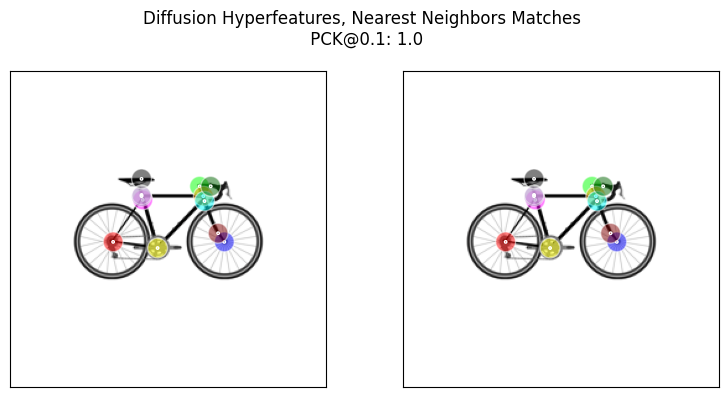

Source hyperfeats: tensor([[[[2.5218e-02, 3.8332e-02, 3.4530e-02,  ..., 1.0050e-01,
           1.2267e-01, 1.2493e-01],
          [4.2104e-02, 8.3495e-02, 6.6021e-02,  ..., 1.1495e-01,
           1.3798e-01, 1.1122e-01],
          [3.5558e-02, 6.8276e-02, 6.2707e-02,  ..., 8.5937e-02,
           9.3615e-02, 8.1980e-02],
          ...,
          [2.0820e-02, 1.7363e-02, 1.9227e-02,  ..., 1.5487e-02,
           2.5833e-02, 9.1847e-03],
          [4.5299e-03, 1.8134e-02, 9.1152e-03,  ..., 7.9435e-03,
           1.8346e-02, 2.4273e-03],
          [1.1058e-02, 2.8136e-03, 2.8136e-03,  ..., 0.0000e+00,
           4.4525e-04, 0.0000e+00]],

         [[1.5695e-01, 2.1773e-01, 1.7738e-01,  ..., 1.9685e-01,
           2.0926e-01, 1.2980e-01],
          [2.8941e-01, 3.6145e-01, 2.7265e-01,  ..., 3.5797e-01,
           3.9074e-01, 1.7978e-01],
          [2.3504e-01, 3.0171e-01, 2.2669e-01,  ..., 2.8612e-01,
           2.9336e-01, 1.2681e-01],
          ...,
          [3.6943e-02, 5.4023e-02, 5.027

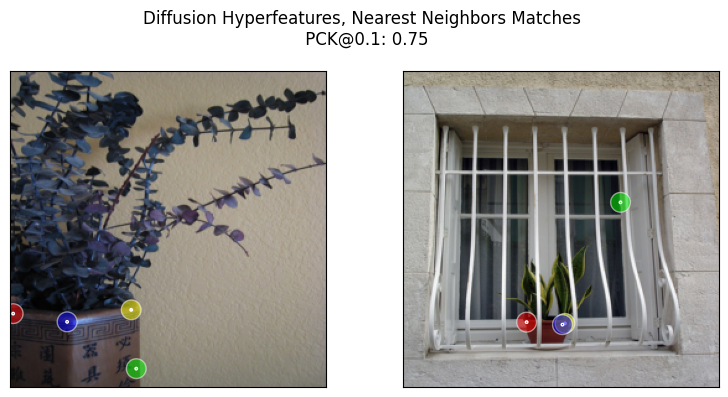

Source hyperfeats: tensor([[[[0.0986, 0.1229, 0.0938,  ..., 0.0923, 0.0962, 0.0881],
          [0.1352, 0.1598, 0.1183,  ..., 0.1048, 0.1158, 0.0929],
          [0.1274, 0.1674, 0.1323,  ..., 0.1235, 0.1047, 0.0877],
          ...,
          [0.0316, 0.0639, 0.0621,  ..., 0.0000, 0.0000, 0.0029],
          [0.0321, 0.0660, 0.0638,  ..., 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0283, 0.0279,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0307, 0.0491, 0.0663,  ..., 0.0044, 0.0063, 0.0010],
          [0.0748, 0.1177, 0.1125,  ..., 0.0177, 0.0210, 0.0052],
          [0.0695, 0.1054, 0.1154,  ..., 0.0143, 0.0190, 0.0046],
          ...,
          [0.3910, 0.5310, 0.6447,  ..., 0.5673, 0.5713, 0.3029],
          [0.4273, 0.5896, 0.6886,  ..., 0.6100, 0.6084, 0.3408],
          [0.2986, 0.3868, 0.4346,  ..., 0.3549, 0.3646, 0.2341]],

         [[0.0241, 0.0145, 0.0227,  ..., 0.0840, 0.0485, 0.0405],
          [0.0171, 0.0140, 0.0152,  ..., 0.0998, 0.0661, 0.0362],
          [0.0108, 0.01

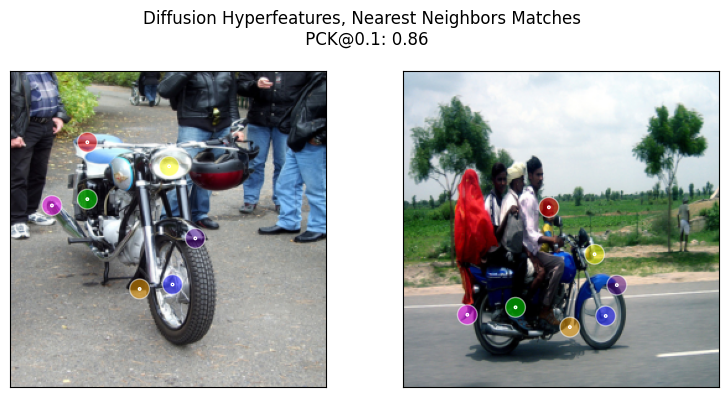

Source hyperfeats: tensor([[[[0.3381, 0.3770, 0.3750,  ..., 0.0746, 0.1030, 0.0893],
          [0.3823, 0.4687, 0.4661,  ..., 0.0980, 0.1463, 0.0981],
          [0.3590, 0.4415, 0.4375,  ..., 0.0849, 0.1280, 0.0866],
          ...,
          [0.0202, 0.0296, 0.0303,  ..., 0.0234, 0.0210, 0.0092],
          [0.0202, 0.0296, 0.0299,  ..., 0.0103, 0.0127, 0.0012],
          [0.0192, 0.0165, 0.0206,  ..., 0.0020, 0.0080, 0.0000]],

         [[0.2917, 0.4024, 0.4097,  ..., 0.3188, 0.3567, 0.2317],
          [0.4136, 0.5818, 0.5928,  ..., 0.6419, 0.6450, 0.3300],
          [0.3694, 0.5282, 0.5410,  ..., 0.7096, 0.7033, 0.3549],
          ...,
          [0.0122, 0.0356, 0.0439,  ..., 0.1998, 0.1893, 0.0837],
          [0.0260, 0.0556, 0.0625,  ..., 0.1684, 0.1555, 0.0570],
          [0.0054, 0.0084, 0.0174,  ..., 0.0595, 0.0432, 0.0168]],

         [[0.0493, 0.0489, 0.0417,  ..., 0.0350, 0.0618, 0.0710],
          [0.0443, 0.0608, 0.0481,  ..., 0.1013, 0.1176, 0.0743],
          [0.0273, 0.04

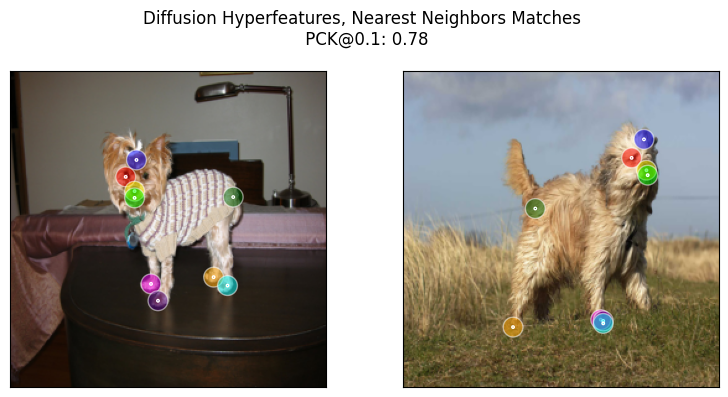

: 

In [5]:
for ann in json.load(open(annotation_path)):
  source_points, target_points, img1_pil, img2_pil, imgs = load_image_pair(ann, load_size, device, image_path)
  
  with torch.inference_mode():
    with torch.autocast("cuda"):
      feats, _ = diffusion_extractor.forward(imgs)
      b, s, l, w, h = feats.shape
      diffusion_hyperfeats = aggregation_network(feats.float().view((b, -1, w, h)))
      img1_hyperfeats = diffusion_hyperfeats[0][None, ...]
      print(f"Source hyperfeats: {img1_hyperfeats}")
      img2_hyperfeats = diffusion_hyperfeats[1][None, ...]
      print(f"Target hyperfeats: {img2_hyperfeats}")


  if correspondence_function == "nearest_neighbors":
    _, predicted_points = find_nn_source_correspondences(img1_hyperfeats, img2_hyperfeats, source_points, output_size, load_size)
    predicted_points = predicted_points.detach().cpu().numpy()
    print(predicted_points)
    distances, _, pck_metric = compute_pck(predicted_points, target_points, load_size)
    title = f"Diffusion Hyperfeatures, Nearest Neighbors Matches \n PCK@0.1: {pck_metric.round(decimals=2)}"
  elif correspondence_function == "best_buddies":
    descriptors1, descriptors2 = reshape_descriptors(img1_hyperfeats, img2_hyperfeats)
    saliency_map1, saliency_map2 = load_saliency_pair(ann, output_size, img1_hyperfeats.device, saliency_path)
    source_points, predicted_points = find_best_buddies_correspondences(descriptors1, descriptors2, saliency_map1, saliency_map2, num_pairs=num_pairs)
    source_points, predicted_points = postprocess_points(source_points, predicted_points, output_size, load_size)
    title = "Diffusion Hyperfeatures, Best Buddies Matches"
  else:
    raise NotImplementedError
  
  draw_correspondences(source_points, predicted_points, img1_pil, img2_pil, title=title)
  plt.show()